In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Limitations of Fixed Basis Functions
Or: *Why single-layer linear models like regression aren't enough*

Linear models for classification (like logistic regression) are based on linear combinations of basis functions $\phi_j(\mathbf{x})$ and take the form:
$$y(\mathbf{x}, \mathbf{w}) = f \bigg(\sum_{j=1}^M w_j\phi_j(\mathbf{x}) + w_0)$$
Where $f(\cdot)$ is a nonlinear output activation function (like softmax or sigmoid). OLS takes the same form but replaces $f(\cdot)$ with the identity activation function (aka. link function).

Because general linear models allow for an arbitrary set of nonlinear basis functions $\{\phi_i(\mathbf{x})\}$, the can in principal provide a solution to *any* regression or classification problem.

### The Curse of Dimensionality

Let's examine some characteristics of high-dimensional spaces. Consider a hypersphere in $D$-dimensional space with radius $r=1$. What fraction of the hypersphere's volumne lies between radius $r=1-\epsilon$ and $r=1$?\
Let volume be: $$V_D(r) = K_Dr^D$$ Where $K_D$ is a constant that depends only on the dimensions $D$.\
The fraction of total volume is given by: $$\frac{V_D(1) - V_D(1-\epsilon)}{V_D(1)} = 1 - (1-\epsilon)^D$$

As $D$ increases, this fraction increases towards $1$, even for very small $\epsilon$. Ex:

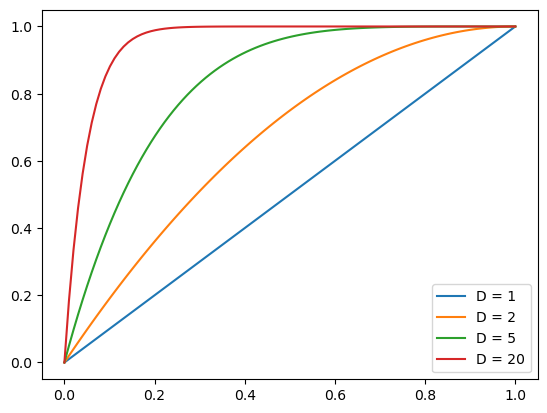

In [16]:
def volume(D, eps): return 1 - (1 - eps)**D

eps = np.linspace(0, 1, 100)
for D in [1, 2, 5, 20]:
    plt.plot(eps, [volume(D=D, eps=eps) for eps in eps], label=f"D = {D}");
plt.legend();

So, we see a remarkable result that in spaces of high dimensionality, most of the volume of the hypersphere becomes concentrated in a thin shell near its surface...\
As dimensions increase, the distance between points increases exponentially, causing effictive sparsity in datasets to increase exponentially.

## Data Manifolds

One reason that ML techniques can be effective despite the curse of dimensionality is that real data are generally confined to regions of space that have lower effective dimensionality.